# Bank marketing tabular experiment

Set up the training environment and the datamodule

In [9]:
import torch
from torch import nn
from torch.optim import Adam
from torch_uncertainty import TUTrainer
from torch_uncertainty.datamodules.classification import BankMarketingDataModule
from torch_uncertainty.models.mlp import mlp
from torch_uncertainty.routines import ClassificationRoutine

torch.manual_seed(42)
NUM_EPOCHS = 10
DEVICE = "cuda:0"
SAVE_IMG = False

trainer = TUTrainer(max_epochs=NUM_EPOCHS, devices=(int(DEVICE.split(":")[1]),))
dm = BankMarketingDataModule("data", batch_size=128, test_split=0.8)
dm.prepare_data()
dm.setup()
num_features = dm.dataset.num_features

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Train the CE-based model

In [10]:
model = mlp(in_features=num_features, num_outputs=1, hidden_dims=[4 * num_features, 2 * num_features])
optim_recipe = Adam(model.parameters(), lr=0.001)
routine = ClassificationRoutine(model, num_classes=1, loss=nn.BCEWithLogitsLoss(), optim_recipe=optim_recipe)
trainer.fit(routine, dm)
trainer.test(routine, dm);

/home/soumik/miniconda3/envs/tu/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `FPR95` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name             | Type              | Params | Mode 
---------------------------------------------------------------
0 | model            | _MLP              | 46.6 K | train
1 | loss             | BCEWithLogitsLoss | 0      | train
2 | format_batch_fn  | Identity          | 0      | train
3 | val_cls_metrics  | MetricCollection  | 0      | train
4 | test_cls_metrics | MetricCollection  | 0      | train
5 | test_id_entropy  | Entropy           | 0      | train
6 | mixup            | Identity          | 0      | train
---------------------------------------------------------------
46.6 K    Trainable params
0         Non-trainable params
46.6 K    Total par

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/soumik/miniconda3/envs/tu/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


/home/soumik/miniconda3/envs/tu/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 65/65 [00:02<00:00, 22.76it/s, v_num=153, train_loss=0.152, Acc%=90.10]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 65/65 [00:02<00:00, 22.63it/s, v_num=153, train_loss=0.152, Acc%=90.10]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/soumik/miniconda3/envs/tu/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 258/258 [00:03<00:00, 72.30it/s]


┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃      Classification       ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     AUPR     │          57.147%          │
│    AUROC     │          92.342%          │
│     Acc      │          90.143%          │
│    Brier     │          0.06821          │
│   Entropy    │          0.08557          │
│    FRP95     │          0.24897          │
│     NLL      │          0.04802          │
└──────────────┴───────────────────────────┘
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃        Calibration        ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     ECE      │          0.03300          │
│     aECE     │          0.03148          │
└──────────────┴───────────────────────────┘
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃ Selective Classification  ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    AUGRC     │          1.355%           │
│     AURC     │          1.633%           │
│  Cov@5Risk   │          87.120%          │
│  Risk@80Cov  │          2.807%           │
└──────────────┴───────────────────────────┘

Train the LS-based model

In [11]:
from torch_uncertainty.losses.classification import BCEWithLogitsLSLoss

ls_trainer = TUTrainer(max_epochs=NUM_EPOCHS, devices=(int(DEVICE.split(":")[1]),))
ls_model = mlp(in_features=num_features, num_outputs=1, hidden_dims=[4 * num_features, 2 * num_features])
optim_recipe = Adam(ls_model.parameters(), lr=0.001)
ls_routine = ClassificationRoutine(
    ls_model, num_classes=1, loss=BCEWithLogitsLSLoss(label_smoothing=0.4), optim_recipe=optim_recipe
)
ls_trainer.fit(ls_routine, dm)
ls_trainer.test(ls_routine, dm);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/soumik/miniconda3/envs/tu/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `FPR95` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name             | Type                | Params | Mode 
-----------------------------------------------------------------
0 | model            | _MLP                | 46.6 K | train
1 | loss             | BCEWithLogitsLSLoss | 0      | train
2 | format_batch_fn  | Identity            | 0      | train
3 | val_cls_metrics  | MetricCollection    | 0      | train
4 | test_cls_metrics | MetricCollection    | 0      | train
5 | test_id_entropy  | Entropy             | 0      | train
6 | mixup            | Identity            | 0      | train
-----------------------------------------------------------------
46.6 K    Trainable params
0         Non-trainable params

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/soumik/miniconda3/envs/tu/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


/home/soumik/miniconda3/envs/tu/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 65/65 [00:02<00:00, 22.58it/s, v_num=154, train_loss=0.573, Acc%=90.80] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 65/65 [00:02<00:00, 22.48it/s, v_num=154, train_loss=0.573, Acc%=90.80]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/soumik/miniconda3/envs/tu/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 258/258 [00:03<00:00, 72.89it/s]


┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃      Classification       ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     AUPR     │          57.592%          │
│    AUROC     │          91.169%          │
│     Acc      │          90.786%          │
│    Brier     │          0.09106          │
│   Entropy    │          0.32565          │
│    FRP95     │          0.33194          │
│     NLL      │          0.01132          │
└──────────────┴───────────────────────────┘
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃        Calibration        ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     ECE      │          0.15262          │
│     aECE     │          0.15117          │
└──────────────┴───────────────────────────┘
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃ Selective Classification  ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    AUGRC     │          1.457%           │
│     AURC     │          2.111%           │
│  Cov@5Risk   │          88.389%          │
│  Risk@80Cov  │          2.803%           │
└──────────────┴───────────────────────────┘

Compute the logits

In [14]:
from torch_uncertainty_ls.utils import risk_coverage_curve

routine = routine.to(DEVICE)
ls_routine = ls_routine.to(DEVICE)
scores = []
logits = []
scores_ls = []
logits_ls = []
correct_samples = []
correct_samples_ls = []

with torch.no_grad():
    for x, y in dm.test_dataloader()[0]:
        x = x.to(DEVICE)
        logit = routine(x).double()
        logit_ls = ls_routine(x).double()
        y_hat = logit.sigmoid().cpu().squeeze(-1)
        y_hat_ls = logit_ls.sigmoid().cpu().squeeze(-1)
        score, predicted = torch.max(y_hat, 1 - y_hat), y_hat > 0.5
        score_ls, predicted_ls = torch.max(y_hat_ls, 1 - y_hat_ls), y_hat_ls > 0.5
        correct = predicted == y
        correct_ls = predicted_ls == y
        logits.append(logit)
        logits_ls.append(logit_ls)
        scores.append(score)
        scores_ls.append(score_ls)
        correct_samples.append(correct)
        correct_samples_ls.append(correct_ls)

logits = torch.cat(logits)
logits_ls = torch.cat(logits_ls)
scores = torch.cat(scores)
scores_ls = torch.cat(scores_ls)
correct_samples = torch.cat(correct_samples)
correct_samples_ls = torch.cat(correct_samples_ls)

ce_risk, ce_cov, thresholds = risk_coverage_curve(correct_samples, scores)
ls_risk, ls_cov, thresholds_ls = risk_coverage_curve(correct_samples_ls, scores_ls)

Plot and optionally save the curves

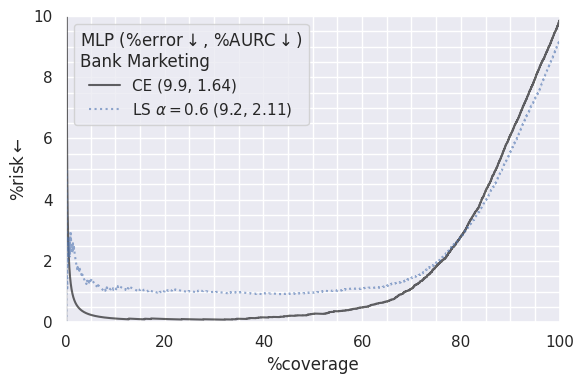

In [15]:
import matplotlib.pyplot as plt
import seaborn

seaborn.set_theme()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(
    ce_cov * 100,
    ce_risk * 100,
    label=f"CE ({ce_risk[-1]*100:.1f}, {torch.trapz(ce_risk,ce_cov).item()*100:.2f})",
    alpha=0.6,
    color="black",
)
ax.plot(
    ls_cov * 100,
    ls_risk * 100,
    label=f"LS $\\alpha=0.6$ ({ls_risk[-1]*100:.1f}, {torch.trapz(ls_risk, ls_cov).item()*100:.2f})",
    alpha=0.6,
    linestyle="dotted",
)
ax.set_xlabel("%coverage")
ax.set_ylabel("%risk$\leftarrow$")
ax.legend(title="MLP (%error$\downarrow$, %AURC$\downarrow$)\nBank Marketing")
ax.grid(visible=True, which="both")
ax.set_xlim(0, 100)
ax.set_ylim(0, 10)
ax.minorticks_on()
fig.tight_layout()

if SAVE_IMG:
    plt.savefig("risk_coverage_curve_bank_marketing.pdf", dpi=300)

plt.show()